<h1><center><font size="6">Predicting Credit Card Fraud</font></center></h1>

<h3><center><font size="4"> https://www.kaggle.com/mlg-ulb/creditcardfraud </font></center></h2>

In [1]:
# The hyperparam only does the grid search but with precision_at_recall_threshold measure. The resampling is done outside

<a id="top"></a> <br>
## Table of  Contents
1. [Introduction](#1)
1. [Initialization](#2)
    1. [Load Packages](#21)
    1. [Define Metadata](#22)
    
1. [Load Data & Validate Reduce Memory](#3)

1. [Hyperparameter Tuning](#4)
    1. [Data Prep](#41)
        1. [Memory Footprint Reduction](#411)
        1. [Data Splitting](#412)
    1. [Search Algorithms - GridSearchCV](#42)

1. [Test Performance](#5)
    1. [Modelling Workflow](#51)
    
1. [Export Data, Pickled Model and Tuned Params](#6)

1. [References](#7)

## <a id='1'>Introduction</a>  
We will use the raw data to perform hyperparameter tuning on the Random Forest model after resampling

## <a id='2'>Initialization</a>  

### <a id='21'>Load Packages</a>  

Load the minimum number of packages to get started and add more as we go along

In [2]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
# This is to suppress any deprecation warnings 

import os

import sys
sys.path.append("/home/paperspace/Kaggle Grandmaster/Udemy Superstar/Classification") # Adds higher directory to python modules path.


### <a id='22'>Define Metadata</a>  

In [3]:
# Define the name of the target class column here instead of manually typing it out everywhere
target_class_name = 'Class'

# Fill in the names of what you want to call the 0 and 1 class
labels = ['Non-Fraud', 'Fraud']

input_file_name = 'creditcard.csv'

intermediate_data_path = 'intermediate data/'

output_df_file_name = 'week4_cleaned_df_output_' 
tuned_model_name = 'week4_rf_on_engineered_df_'
tuned_model_params_name = 'week4_grid_search_rf_params_'

# Enter the date in which this notebook is run
export_date = '20200424'

In [4]:
# Check ou tthe names of the files in the input folder that we need to load as dataframe
import os
print(os.listdir('../input'))
# This will list all the files in this folder

['creditcard.csv']


## <a id='3'>Load Data & Validate</a>  

In [5]:
df = pd.read_csv('../input/' + input_file_name)
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
190271,128764.0,-0.925423,1.485747,-1.520985,-0.007618,3.564272,3.527816,0.821759,0.957055,-1.226911,...,-0.030017,-0.038729,-0.549141,0.594941,1.155092,-0.204153,-0.333146,-0.220568,21.87,0
229526,145960.0,2.114728,-0.124577,-1.395241,0.247095,0.155624,-0.801416,0.117737,-0.244220,0.706687,...,-0.347342,-0.899032,0.256264,-0.736342,-0.223408,0.245085,-0.076623,-0.069176,1.79,0
223050,143227.0,-4.303095,2.621348,-0.804766,-0.776119,-1.892081,-0.618063,-1.030647,1.561722,1.432966,...,0.173539,0.738320,0.081825,0.016671,0.170976,0.538864,-0.972460,-0.200730,31.26,0
22104,32038.0,0.816482,-0.647617,-0.612796,0.104169,-0.221656,-0.811799,0.661003,-0.295371,-0.417911,...,0.134773,-0.192733,-0.360372,0.111842,0.472798,1.046044,-0.165315,0.021406,259.00,0
171545,120689.0,1.894358,-0.335510,-0.474475,0.421134,-0.501457,0.122493,-0.969691,0.283467,1.042078,...,0.034940,0.182814,0.315294,0.616307,-0.604181,0.322196,0.005513,-0.008982,19.65,0


Lets check the head & tail to make sure there is nothing going on

In [6]:
df.head(3)
# What you are checking here is whether there are some unwanted headers from teh input file that 
# can corrupt our data
# If found, either open the file and manually delete it or only load the relevant columns

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [7]:
df.tail(3)
# similar logic here

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


No data corruption seen in either the head or the tail

In [8]:
# Lets see the data structure
df.info()
# They all seem to have been correctly read 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

All good to proceed

## <a id='4'>Hyperparam Tuning</a>  

### <a id='41'>Data Prep

#### <a id='411'>Memory Footprint Reduction

In [9]:
from helper_functions_comprehensive import reduce_mem_usage_function
df, NAlist = reduce_mem_usage_function(df)

# Always reduce the dataset right after loading 
#even if you are sure that when exporting it you have reduced it
# This is because Pandas inflates the size of the data

Memory usage of dataframe is 67.36 MB
Column Time dtype after is uint32 
******************************
Column V1 dtype after is float32 
******************************
Column V2 dtype after is float32 
******************************
Column V3 dtype after is float32 
******************************
Column V4 dtype after is float32 
******************************
Column V5 dtype after is float32 
******************************
Column V6 dtype after is float32 
******************************
Column V7 dtype after is float32 
******************************
Column V8 dtype after is float32 
******************************
Column V9 dtype after is float32 
******************************
Column V10 dtype after is float32 
******************************
Column V11 dtype after is float32 
******************************
Column V12 dtype after is float32 
******************************
Column V13 dtype after is float32 
******************************
Column V14 dtype after is float32 
************

#### <a id='412'>Data Splitting

#### Feature - Target split

In [10]:
X = df.drop(target_class_name, axis=1)
y = df[target_class_name]

##### Train - Test Split

In [11]:
# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print('Length of (train): {} | positives in y (train): {}'.format(len(X_train), sum(y_train)))
print('Length of (test): {} | positives in y (test): {}'.format(len(X_test), sum(y_test)))

Length of (train): 227845 | positives in y (train): 394.0
Length of (test): 56962 | positives in y (test): 98.0


### <a id='42'>Search Algorithms GridSearchCV

Q Why do you need to pass in your custom scoring function instead of the default?
Because grid search uses accuracy by default which we know ahead of time that its not the right metric for imbalanced datasets

https://stackoverflow.com/questions/32889929/gridsearchcv-scoring-parameter-using-scoring-f1-or-scoring-none-by-default-u

You have the option to select one of these built in scoring functions

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://www.kaggle.com/c/expedia-hotel-recommendations/discussion/21154

In [12]:
%%time

from helper_functions_comprehensive import metrics_store_function, augment_data_function, tune_grid_search_function

from sklearn.ensemble import RandomForestClassifier
# from collections import Counter

# This is for the hyperparam tuning and KFold CV
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

# Classification metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, fbeta_score

# Higher Number of decision trees used in the ensemble will increase the accuracy
n_estimators = [10, 20, 50, 100]

# Increasing number of levels in tree may cause overfitting
max_depth = [6, 7, 8, 9, 10]

# Higher number of samples required to split a node will reduce overfitting
min_samples_split = [10, 20, 50, 100]

# Higher number of samples required at each leaf node will also reduce overfitting
min_samples_leaf = [10, 20, 50, 100]

# Create the grid for the random search. 
rf_params = {'n_estimators': n_estimators,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf}

# For now, we will be keeping the same classifier as what was used in the previous weeks
classifier_type = RandomForestClassifier

# Keep a holdout set that has not been sampled
cv_fold_X_train, cv_fold_X_val, cv_fold_y_train, cv_fold_y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2, random_state=42, stratify=y_train)


X_train_resampled, y_train_resampled = augment_data_function(cv_fold_X_train, cv_fold_y_train,  
                                           positive_upsampling_ratio=4, negative_upsampling_ratio=2)

hyperparam_results = tune_grid_search_function(X_train_resampled, y_train_resampled, cv_fold_X_val, cv_fold_y_val,
                                                 rf_params, classifier_type = classifier_type)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 25

CPU times: user 1min 29s, sys: 7.3 s, total: 1min 37s
Wall time: 4h 35min 24s


In [13]:
classification_metrics_dict = hyperparam_results['classification_metrics']

######### Pretty print
print('---' * 45)
print('')

print("Accuracy: {}".format(round(classification_metrics_dict['accuracy'],4)))
print("Precision: {}".format(round(classification_metrics_dict['precision']),4))
print("Recall: {}".format(round(classification_metrics_dict['recall'],4)))
print("F1: {}".format(round(classification_metrics_dict['f1'],4)))
print("AUC ROC: {}".format(round(classification_metrics_dict['roc_auc'],4)))
print("F2: {}".format(round(classification_metrics_dict['f2'],4)))

#     print('Custom metric is {}'.format(hyperparam_results['custom_metric']))
print('---' * 45)



---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.9993
Precision: 1.0
Recall: 0.7468
F1: 0.7919
AUC ROC: 0.8733
F2: 0.9993
---------------------------------------------------------------------------------------------------------------------------------------


Check out how the best params look like

In [21]:
hyperparam_results

Counter({'internal_grid_search_scores': [0.9755119700826043,
          0.9809162444492804,
          0.978254128272444,
          0.9817760770611507,
          0.9756082447461811,
          0.979138545245881,
          0.9791466342223818,
          0.9800310390866557,
          0.9747629944165124,
          0.9738785895522387,
          0.9729533542632817,
          0.972068949399008,
          0.972068949399008,
          0.9737829644761785,
          0.972068949399008,
          0.972068949399008,
          0.970300030525099,
          0.9729221310110817,
          0.9720931816719292,
          0.971192512146124,
          0.9729533542632817,
          0.9738458358843068,
          0.9729533542632817,
          0.971192512146124,
          0.9694156256608254,
          0.972068949399008,
          0.972068949399008,
          0.972068949399008,
          0.9712233180666868,
          0.9738065358753554,
          0.972068949399008,
          0.971192512146124,
          0.96940754890

In [27]:
len(hyperparam_results['internal_grid_search_scores'])
# This contains all average cv scores during the grid search

320

In [36]:
from sklearn.model_selection import ParameterGrid
param_combo_list = []
for combo in ParameterGrid(rf_params):
    param_combo_list.append(combo)

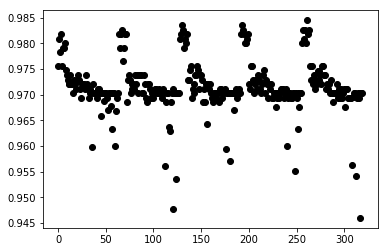

In [38]:
x = range(len(param_combo_list))

plt.plot(x, hyperparam_results['internal_grid_search_scores'], 'o', color='black');

In [ ]:
# If you have more time, you can run a more refined grid search closer to the 'earlier' combinations of the params

## <a id = 5> Test Performance

### <a id='51'>Data Prepping</a> 

In [22]:
# Use the algorithm from Week 2 for the resampling techniques
from helper_functions_comprehensive import augment_data_function

X_resampled_train, y_resampled_train = augment_data_function(X_train, y_train, 
                                                             positive_upsampling_ratio=4, negative_upsampling_ratio=2)
print(X_resampled_train.shape,sum(y_resampled_train))

(456478, 30) 1576.0


### <a id='52'>Modelling Workflow </a> 

Lets use the best params found in the previous analysis

In [23]:
classifier = RandomForestClassifier(**hyperparam_results['best_params'], n_jobs = -1, random_state=42)

classifier.fit(X_resampled_train, y_resampled_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Has a Train accuracy of 100.0 % 
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    454902
       Fraud       0.98      0.94      0.96      1576

   micro avg       1.00      1.00      1.00    456478
   macro avg       0.99      0.97      0.98    456478
weighted avg       1.00      1.00      1.00    456478

The ROC AUC Score on Train set is 0.99
Confusion matrix, without normalization
[[454875     27]
 [    92   1484]]


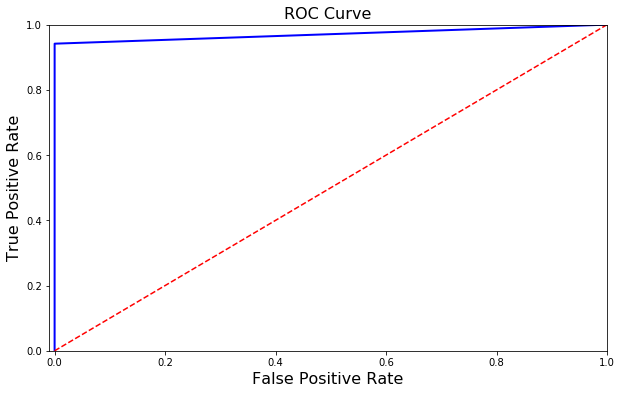

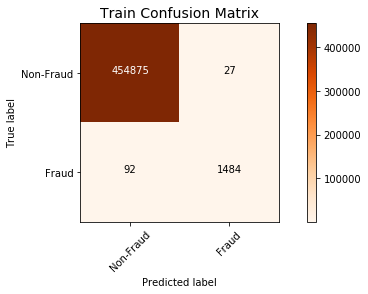

In [24]:
from helper_functions_comprehensive import custom_classification_metrics_function
custom_classification_metrics_function(X_resampled_train, y_resampled_train, labels, classifier, data_type='Train')

Has a Test accuracy of 100.0 % 
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.86      0.81      0.83        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.93      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962

The ROC AUC Score on Test set is 0.97
Confusion matrix, without normalization
[[56851    13]
 [   19    79]]


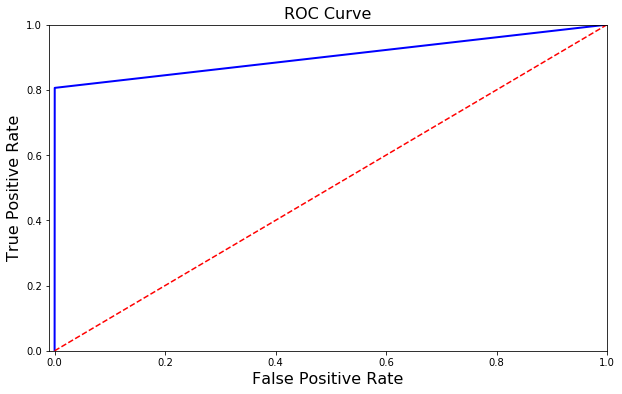

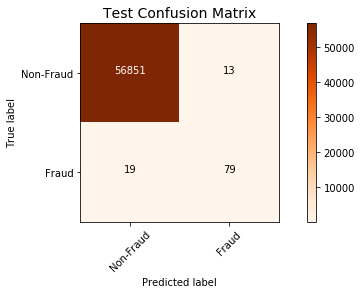

In [25]:
custom_classification_metrics_function(X_test, y_test, labels, classifier, data_type='Test')

In [26]:
from helper_functions_comprehensive import precision_at_recall_threshold_function

predicted_proba = classifier.predict_proba(X_test)[:,1]
threshold_precision = precision_at_recall_threshold_function(y_test, predicted_proba, recall_threshold=0.85)

# For comparison, lets print the precision at the recall threshold of 85%
print(threshold_precision)

0.8


## <a id=6 >Export Data, Pickled Model and Tuned Params

In [39]:
import pickle

# Dump the tuned model
pickle.dump(classifier, open(tuned_model_name + export_date + '.pkl', 'wb'))
 
# Dump the tuned params 
pickle.dump(hyperparam_results['best_params'], open(tuned_model_params_name + export_date + '.pkl', 'wb'))


## <a id=7 > References

F1 score vs ROC AUC
https://stats.stackexchange.com/questions/210700/how-to-choose-between-roc-auc-and-f1-score

https://stackoverflow.com/questions/34698161/how-to-interpret-almost-perfect-accuracy-and-auc-roc-but-zero-f1-score-precisio#34698935

https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc
